In [75]:
DATA_TRAIN_RAW = '../data/raw/train.csv'
DATA_TRAIN_PROCESSED = '../data/prepocessed/train.csv'

# Import 

## Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Admin\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Define

In [46]:
def plot_series(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Series", color='blue', alpha=0.7)
        
    plt.xlabel("Time")
    plt.ylabel("Tempurature")

In [3]:
def is_stationary_ADF(series):
    result = adfuller(series)

    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])

    # Kiểm tra kết quả
    if result[1] < 0.05:
        print("Chuỗi DỪNG (p-value < 0.05)")
    else:
        print("Chuỗi KHÔNG DỪNG (p-value >= 0.05)")


In [40]:
def anomaly_detection_boxplot(data):
    """
    Phát hiện và vẽ boxplot để kiểm tra outliers trong dữ liệu.
    
    Parameters:
        data (pd.Series or list): Dữ liệu đầu vào
        
    Returns:
        outliers (list): Danh sách outliers
    """
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outlier_indices = (data < lower_bound) | (data > upper_bound)
    
    outliers = pd.DataFrame({'Value': data[outlier_indices]})

    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Series", color='blue', alpha=0.7)
    
    plt.scatter(outliers.index, outliers['Value'], color='red', label="Outliers", zorder=3)
    
    plt.xlabel("Time")
    plt.ylabel("Tempurature")
    plt.legend()
    plt.show()
    
    print(f"Detected {len(outliers)} outliers.")
    return outliers

In [83]:
def anomaly_detection_rolling(data, window_size=20, threshold=3):
    """
    Phát hiện bất thường trong chuỗi thời gian bằng rolling mean và rolling std.

    Parameters:
        data (pd.Series): Chuỗi dữ liệu gốc.
        window_size (int): Kích thước cửa sổ trượt.
        threshold (float): Ngưỡng phát hiện outliers (số lần độ lệch chuẩn).

    Returns:
        outliers (pd.DataFrame): DataFrame chứa index và giá trị của outliers.
    """
    rolling_mean = data.rolling(window=window_size).mean()
    rolling_std = data.rolling(window=window_size).std()

    # Xác định ngưỡng trên và dưới
    upper_bound = rolling_mean + threshold * rolling_std
    lower_bound = rolling_mean - threshold * rolling_std

    # Xác định các điểm bất thường
    outlier_indices = (data > upper_bound) | (data < lower_bound)
    outliers = data[outlier_indices]

    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(data, label="Original Data", color='blue', alpha=0.7)
    plt.plot(rolling_mean, label=f"Rolling Mean (window={window_size})", color='green', linestyle="--")
    plt.fill_between(data.index, lower_bound, upper_bound, color='gray', alpha=0.3, label="Threshold Range")
    plt.scatter(outliers.index, outliers, color='red', label="Outliers", zorder=3)

    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Anomaly Detection using Rolling Mean & Std (window={window_size}, threshold={threshold})")
    plt.legend()
    plt.show()

    print(f"Detected {len(outliers)} outliers.")
    return outliers.to_frame(name="Value")

In [61]:
def replace_and_fill_outliers(data, outliers, method="mean"):
    """
    Thay thế outliers trong Series bằng NaN và điền lại bằng các phương pháp khác nhau.
    Vẽ biểu đồ trước và sau khi xử lý, đánh dấu những điểm đã thay thế.

    Parameters:
        data (pd.Series): Chuỗi dữ liệu gốc.
        outliers (pd.DataFrame): DataFrame chứa outliers (từ AD_Boxplot).
        method (str): Phương pháp điền giá trị ['mean', 'backward', 'forward', 'linear'].

    Returns:
        pd.Series: Chuỗi đã xử lý outliers.
    """
    # Tạo bản sao dữ liệu gốc
    cleaned_data = data.copy()

    # Thay thế giá trị outliers bằng NaN
    cleaned_data.loc[outliers.index] = np.nan

    # Điền giá trị theo phương pháp đã chọn
    if method == "mean":
        filled_data = cleaned_data.fillna(cleaned_data.mean())
    elif method == "backward":
        filled_data = cleaned_data.fillna(method="bfill")
    elif method == "forward":
        filled_data = cleaned_data.fillna(method="ffill")
    elif method == "linear":
        filled_data = cleaned_data.interpolate(method="linear")
    else:
        raise ValueError("Phương pháp điền giá trị không hợp lệ. Chọn một trong ['mean', 'backward', 'forward', 'linear']")

    # Xác định min/max của dữ liệu ban đầu
    y_min, y_max = data.min() - 0.1*(data.min()+5), data.max() *1.1

    # Vẽ biểu đồ trước và sau khi xử lý outliers (2 dòng, dùng chung trục x)
    fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Biểu đồ 1: Trước khi xử lý (Hiển thị outliers màu đỏ)
    axes[0].plot(data, label="Original Data", color='blue', alpha=0.7)
    axes[0].scatter(outliers.index, outliers["Value"], color='red', label="Outliers", zorder=3)
    axes[0].set_ylabel("Temperature")
    axes[0].set_title("Before Outlier Handling")
    axes[0].legend()
    axes[0].set_ylim(y_min, y_max)  # Set ylim theo dữ liệu ban đầu

    # Biểu đồ 2: Sau khi xử lý (Hiển thị điểm đã thay thế màu cam)
    axes[1].plot(filled_data, label=f"Filled Data ({method})", color='green', alpha=0.7)
    axes[1].scatter(outliers.index, filled_data.loc[outliers.index], color='orange', label="Replaced Points", zorder=3)
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Temperature")
    axes[1].set_title(f"After Outlier Handling - {method}")
    axes[1].legend()
    axes[1].set_ylim(y_min, y_max)  # Set ylim theo dữ liệu ban đầu

    plt.tight_layout()
    plt.show()

    return filled_data


# Process

In [4]:
data = pd.read_csv(DATA_TRAIN_RAW)

* set index, to datetime

In [6]:
data.index = pd.to_datetime(data['Date'])
data = data.drop('Date', axis=1)

* check wrong value

In [9]:
data = data.rename(columns={'Daily minimum temperatures': 'temperatures'})
data['original_temperatures'] = data['temperatures']
data['temperatures'] = pd.to_numeric(data['temperatures'], errors='coerce').astype(float)

In [10]:
invalid_values = data[data['temperatures'].isna()]
print(invalid_values[['original_temperatures', 'temperatures']])

            original_temperatures  temperatures
Date                                           
1982-07-20                    NaN           NaN
1982-07-21                    NaN           NaN
1984-07-14                    NaN           NaN


In [11]:
start_time = pd.to_datetime("1982-07-15")
end_time = pd.to_datetime("1982-07-25")
data.loc[start_time:end_time]

,temperatures,original_temperatures
Date,,
1982-07-15,3.3,3.3
1982-07-16,5.0,5.0
1982-07-17,3.7,3.7
1982-07-18,3.9,3.9
1982-07-19,5.2,5.2
1982-07-20,NaN,NaN
1982-07-21,NaN,NaN
1982-07-22,0.9,0.9
1982-07-23,3.5,3.5


In [12]:
start_time = pd.to_datetime("1984-07-12")
end_time = pd.to_datetime("1984-07-16")
data.loc[start_time:end_time]

,temperatures,original_temperatures
Date,,
1984-07-12,8.0,8.0
1984-07-13,0.7,0.7
1984-07-14,NaN,NaN
1984-07-15,0.9,0.9
1984-07-16,7.8,7.8


* Fix by value near dataset

In [13]:
na1_idx = pd.to_datetime('1982-07-20')
na2_idx = pd.to_datetime('1982-07-21')
na3_idx = pd.to_datetime('1984-07-14')
data.loc[na1_idx,'temperatures'] = 0.2
data.loc[na2_idx,'temperatures'] = 0.8
data.loc[na3_idx,'temperatures'] = 0.1

In [14]:
data.drop(columns=['original_temperatures'],inplace=True)
data.head()

,temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 1981-01-01 to 1988-12-30
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   temperatures  2920 non-null   float64
dtypes: float64(1)
memory usage: 110.2 KB


In [27]:
data.describe(include='all')

,temperatures
count,2920.000000
mean,11.105753
std,4.060613
min,0.000000
25%,8.300000
50%,11.000000
75%,13.800000
max,26.300000


In [73]:
data

,temperatures
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1988-12-26,9.5
1988-12-27,12.9
1988-12-28,12.9


> Preprocess ok

In [78]:
data.to_csv(DATA_TRAIN_PROCESSED)

# Change point detection (Research)

## Box-plot

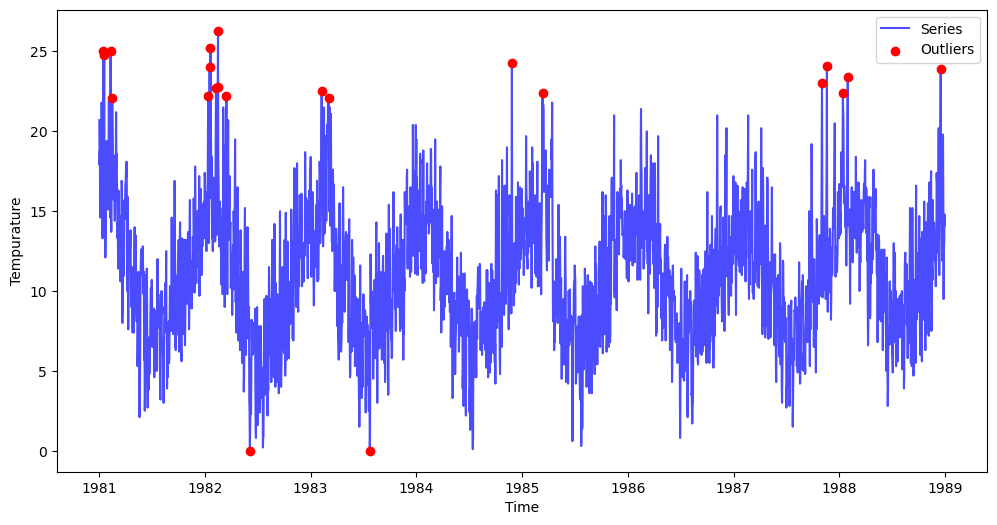

Detected 22 outliers.


In [43]:
outlier_boxplot = anomaly_detection_boxplot(data['temperatures'])

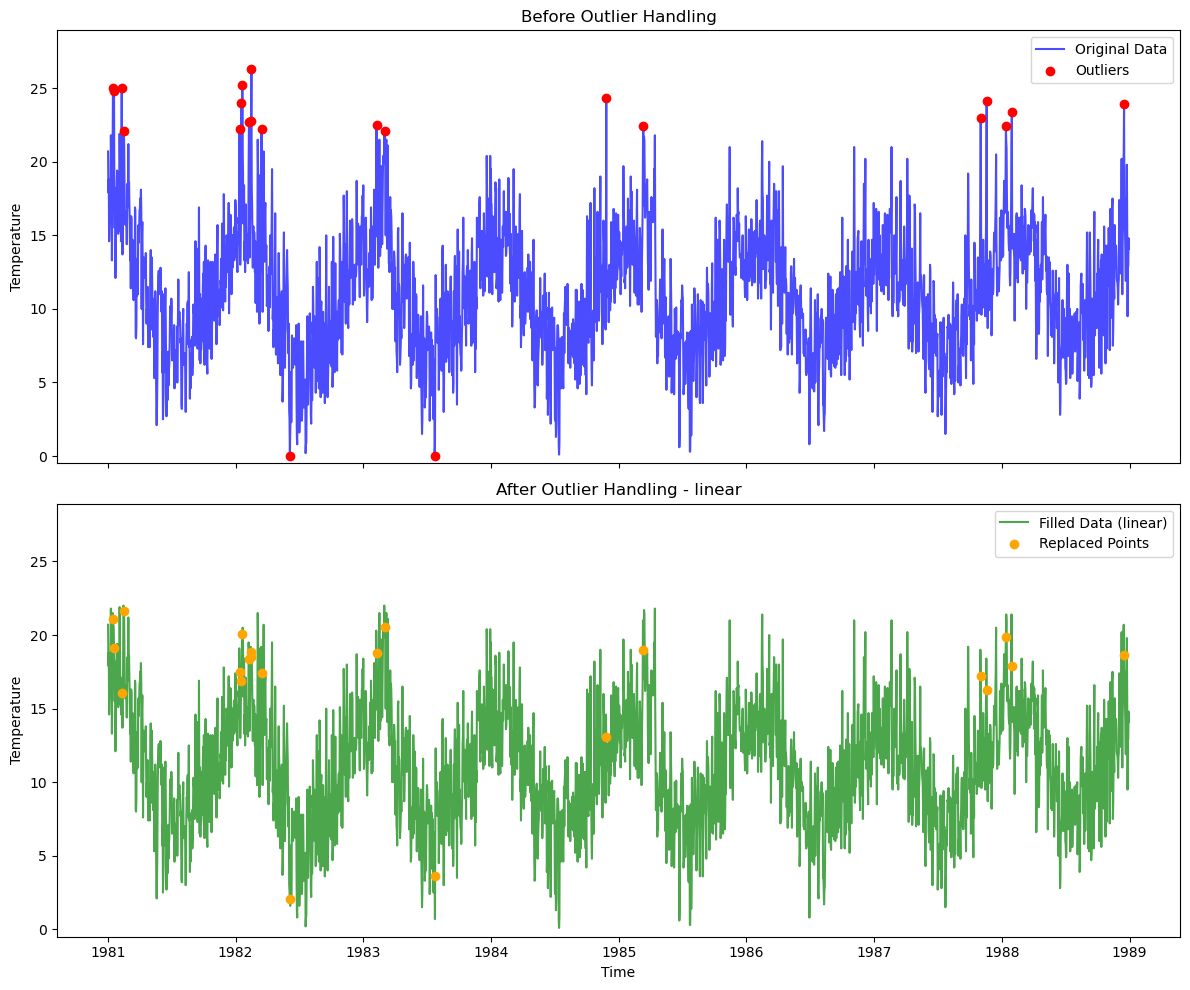

In [63]:
clean_boxplot = replace_and_fill_outliers(data['temperatures'], outlier_boxplot, method='linear')

## Rolling

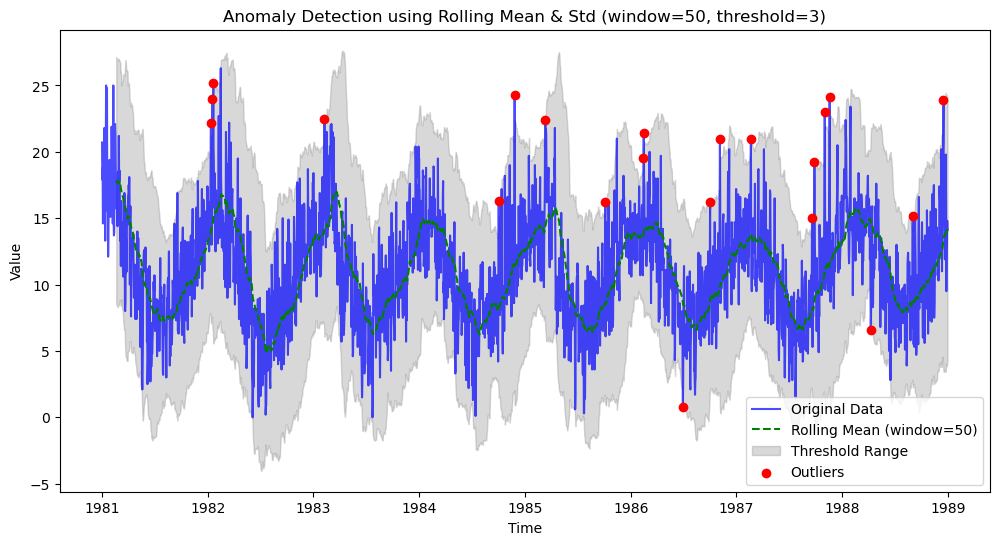

Detected 21 anomalies.


In [81]:
outlier_rolling = anomaly_detection_rolling(data['temperatures'],window_size=50, threshold=3)

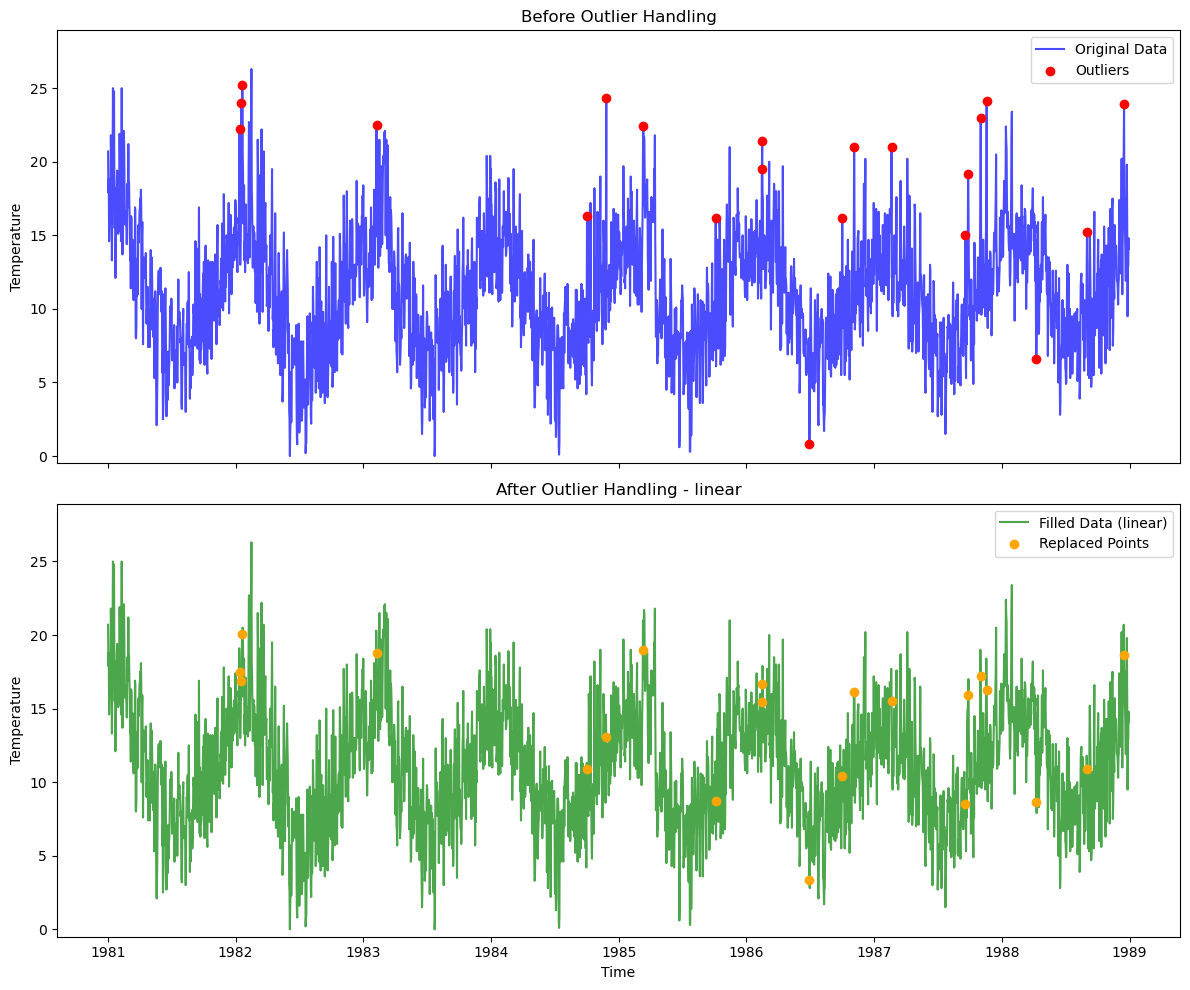

In [82]:
clean_rolling = replace_and_fill_outliers(data['temperatures'], outlier_rolling, method='linear')